<a href="https://colab.research.google.com/github/diriho/Healthcare-bias-revealed-/blob/main/apma_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# import statements
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import matplotlib.ticker
import matplotlib.animation as animation

from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In this presentation, we are going to use a data we got from an open source database of the [STATE HEALTH COMPARE](https://statehealthcompare.shadac.org/table/29/health-insurance-coverage-type-by-race-ethnicity#1/5,4,1,10,86,9,8,6,39,40,41,42,238,43,239/42/57,58)

Due to time limitations, we mainly focused our presentation on studying inequalities present in the domain of the healthcare system and access to insurance--and which types of insurance different people coming from different races/ethnicities have.

In [13]:
with open('/content/Health Insurance Coverage Type by Family Income.csv', 'r') as f:
    dialect = csv.Sniffer().sniff(f.read(2048))


with open('/content/Health Insurance Coverage Type by Race _ Ethnicity.csv', 'r') as f:
    dialect1 = csv.Sniffer().sniff(f.read(2048))


with open('/content/Percent who visited an emergency department in the past year by Coverage Type (2019-2023).csv', 'r') as f:
    dialect2 = csv.Sniffer().sniff(f.read(2048))


data_fam_in = pd.read_csv('/content/Health Insurance Coverage Type by Family Income.csv', delimiter=dialect.delimiter)
data_race = pd.read_csv('/content/Health Insurance Coverage Type by Race _ Ethnicity.csv', delimiter=dialect1.delimiter)
data_prev_record = pd.read_csv('/content/Percent who visited an emergency department in the past year by Coverage Type (2019-2023).csv', delimiter=dialect2.delimiter)

In [14]:
data_fam_in

,Fips,Location,Coverage Type,Family Income,TimeFrame,Data Type,Data,MOE
0,US,United States,Employer,"$25,000 - $49,999",2021,Percent,"0,39143","0,002068"
1,US,United States,Individual,"$25,000 - $49,999",2021,Percent,"0,06217","0,001031"
2,US,United States,Insured,"$25,000 - $49,999",2021,Percent,"0,88266","0,001493"
3,US,United States,Medicaid/CHIP,"$25,000 - $49,999",2021,Percent,"0,21471","0,001932"
4,US,United States,Medicare,"$25,000 - $49,999",2021,Percent,"0,21435","0,001245"
...,...,...,...,...,...,...,...,...
187,US,United States,Medicare,"$25,000 - $49,999",2021,Number,13901656,NaN
188,US,United States,Insured,"$25,000 - $49,999",2021,Number,57244468,NaN
189,US,United States,Medicaid/CHIP,"$25,000 - $49,999",2021,Number,13924704,NaN
190,US,United States,Individual,"$25,000 - $49,999",2021,Number,4032064,NaN


In [15]:
data_race

,Fips,Location,Coverage Type,Race / Ethnicity,TimeFrame,Data Type,Data,MOE
0,US,United States,Employer,African-American / Black,2021,Percent,"0,44929","0,002789"
1,US,United States,Employer,African-American / Black,2021,Number,17180941,NaN
2,US,United States,Individual,African-American / Black,2021,Percent,"0,04706","0,001336"
3,US,United States,Individual,African-American / Black,2021,Number,1799684,NaN
4,US,United States,Insured,African-American / Black,2021,Percent,"0,90433","0,001362"
...,...,...,...,...,...,...,...,...
331,US,United States,Private,White,2023,Percent,"0,61108","0,001397"
332,US,United States,Public,White,2023,Number,64045282,NaN
333,US,United States,Public,White,2023,Percent,"0,33803","0,001105"
334,US,United States,Uninsured,White,2023,Percent,"0,05089","0,000605"


In [16]:
data_prev_record

,Fips,Location,Coverage Type,TimeFrame,Data Type,Data,MOE
0,US,United States,Private,2020-2021,Percent,136,"3,92E-03"
1,US,United States,Public,2020-2021,Percent,256,"9,8E-03"
2,US,United States,Uninsured,2020-2021,Percent,"0,18","1,372E+01"
3,US,United States,Private,2021-2022,Percent,"0,13826","4,24660656E-03"
4,US,United States,Public,2021-2022,Percent,"0,26147","9,62344516E-03"
5,US,United States,Uninsured,2021-2022,Percent,"0,17175","1,195501412E-02"
6,US,United States,Private,2022-2023,Percent,"0,14977","4,29715513487336E-03"
7,US,United States,Public,2022-2023,Percent,"0,28774","1,02865375567723E-02"
8,US,United States,Uninsured,2022-2023,Percent,"0,17638","1,27217136596555E-02"


In [20]:
type_race = data_race.groupby(['Coverage Type', 'Race / Ethnicity']).size().reset_index(name='Count')
type_race

,Coverage Type,Race / Ethnicity,Count
0,Employer,African-American / Black,6
1,Employer,American Indian / Alaska Native,6
2,Employer,Asian,6
3,Employer,Hispanic / Latino,6
4,Employer,Native Hawaiian and Other Pacific Islander,6
5,Employer,Other / Multiple Races,6
6,Employer,White,6
7,Individual,African-American / Black,6
8,Individual,American Indian / Alaska Native,6
9,Individual,Asian,6


**Parse using data presented in percentage**

In [21]:
# Keep only 'Percent' type data
df_percent = data_race[data_race['Data Type'] == 'Percent']

# Focus only on 'Uninsured' coverage type
df_uninsured = df_percent[df_percent['Coverage Type'] == 'Uninsured']

# Focus on the latest year available
latest_year = df_uninsured['TimeFrame'].max()
df_uninsured_latest = df_uninsured[df_uninsured['TimeFrame'] == latest_year]

# Sort by uninsured rate
df_uninsured_latest = df_uninsured_latest.sort_values(by='Data', ascending=True)



<ipython-input-22-642ffd012a22>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


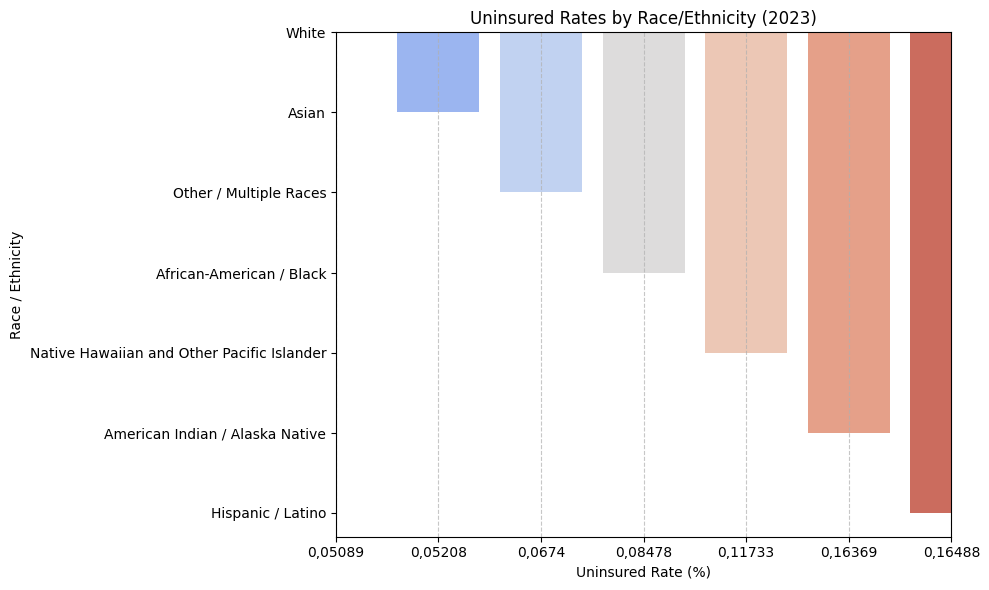

In [22]:
# ==============================
# Plot 1: Barplot of Uninsured Rates by Race
# ==============================
plt.figure(figsize=(10,6))
sns.barplot(
    x='Data',
    y='Race / Ethnicity',
    data=df_uninsured_latest,
    palette='coolwarm'
)
plt.xlabel('Uninsured Rate (%)')
plt.title(f'Uninsured Rates by Race/Ethnicity ({latest_year})')
plt.xlim(0, df_uninsured_latest['Data'].max())
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


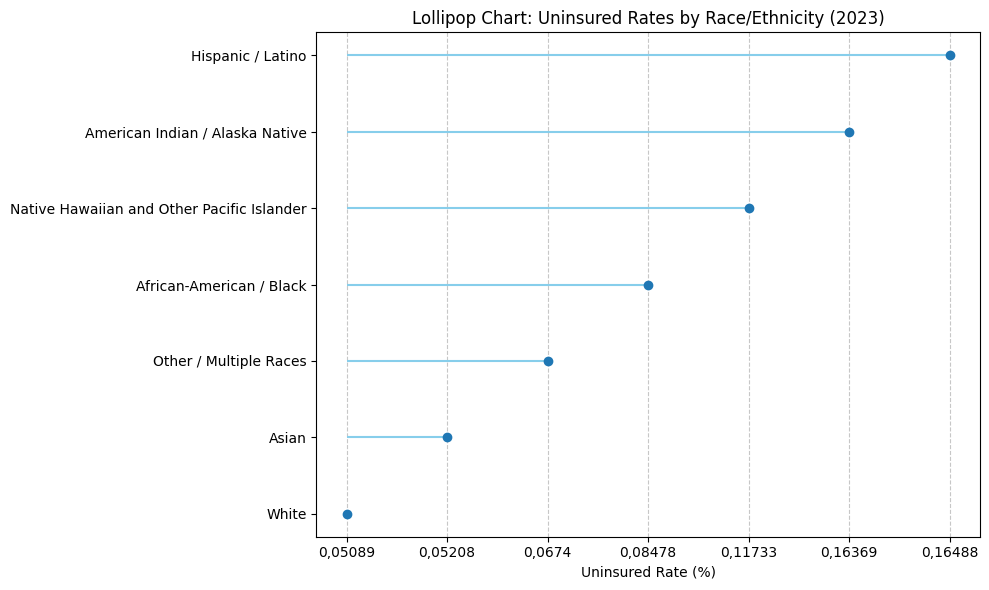

In [23]:
# ==============================
# Plot 2: Horizontal lollipop chart for Uninsured Rates
# ==============================
plt.figure(figsize=(10,6))
plt.hlines(y=df_uninsured_latest['Race / Ethnicity'], xmin=0, xmax=df_uninsured_latest['Data'], color='skyblue')
plt.plot(df_uninsured_latest['Data'], df_uninsured_latest['Race / Ethnicity'], "o")
plt.xlabel('Uninsured Rate (%)')
plt.title(f'Lollipop Chart: Uninsured Rates by Race/Ethnicity ({latest_year})')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [24]:
data_race

,Fips,Location,Coverage Type,Race / Ethnicity,TimeFrame,Data Type,Data,MOE
0,US,United States,Employer,African-American / Black,2021,Percent,"0,44929","0,002789"
1,US,United States,Employer,African-American / Black,2021,Number,17180941,NaN
2,US,United States,Individual,African-American / Black,2021,Percent,"0,04706","0,001336"
3,US,United States,Individual,African-American / Black,2021,Number,1799684,NaN
4,US,United States,Insured,African-American / Black,2021,Percent,"0,90433","0,001362"
...,...,...,...,...,...,...,...,...
331,US,United States,Private,White,2023,Percent,"0,61108","0,001397"
332,US,United States,Public,White,2023,Number,64045282,NaN
333,US,United States,Public,White,2023,Percent,"0,33803","0,001105"
334,US,United States,Uninsured,White,2023,Percent,"0,05089","0,000605"


**Numbers part**

In [36]:
# Keep only 'Number' data
### Clean the 'Data' column by making it numerical instead of a column
data_race['Data'] = data_race['Data'].str.replace(',', '.').astype(float)

df_number = data_race[data_race['Data Type'] == 'Number']   #reflecting the data published in numbers

# Focus on the latest year available
latest_year = df_number['TimeFrame'].max()
df_number_latest = df_number[df_number['TimeFrame'] == latest_year]

# Pivot the data: rows = Race/Ethnicity, columns = Coverage Type
pivot = df_number_latest.pivot_table(
    index='Race / Ethnicity',
    columns='Coverage Type',
    values='Data',
    aggfunc='sum'  # in case there are duplicates
)



In [51]:
pivot

Coverage Type,Employer,Individual,Insured,Medicaid/CHIP,Medicare,Private,Public,Uninsured
Race / Ethnicity,,,,,,,,
African-American / Black,17599758.0,1864210.0,35362781.0,9677281.0,6221532.0,19463968.0,15898813.0,3275587.0
American Indian / Alaska Native,594083.0,55418.0,1411079.0,498917.0,262661.0,649501.0,761578.0,276181.0
Asian,11592279.0,1919708.0,18686898.0,2370392.0,2804519.0,13511987.0,5174911.0,1026780.0
Hispanic / Latino,27461215.0,4030083.0,53975995.0,16551331.0,5933366.0,31491298.0,22484697.0,10656530.0
Native Hawaiian and Other Pacific Islander,290220.0,30428.0,502247.0,120377.0,61222.0,320648.0,181599.0,66764.0
Other / Multiple Races,9423262.0,1028173.0,15476610.0,3358178.0,1666997.0,10451435.0,5025175.0,1118466.0
White,103683181.0,12098314.0,179826777.0,19386340.0,44658942.0,115781495.0,64045282.0,9642123.0


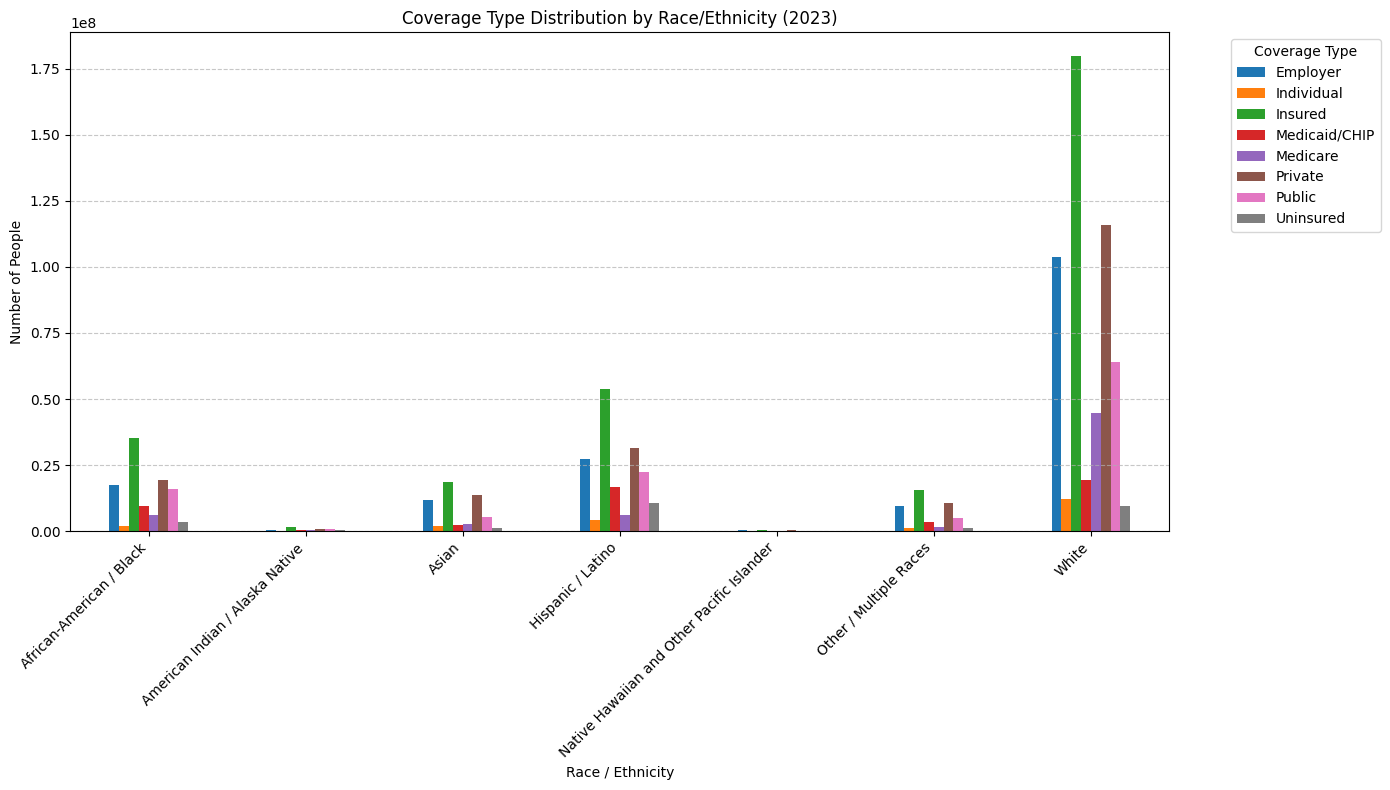

In [39]:
# ============================
# Plot 1: Grouped Bar Chart
# ============================
pivot.plot(kind='bar', figsize=(14,8), stacked=False)
plt.title(f'Coverage Type Distribution by Race/Ethnicity ({latest_year})')
plt.ylabel('Number of People')
plt.xlabel('Race / Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Coverage Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


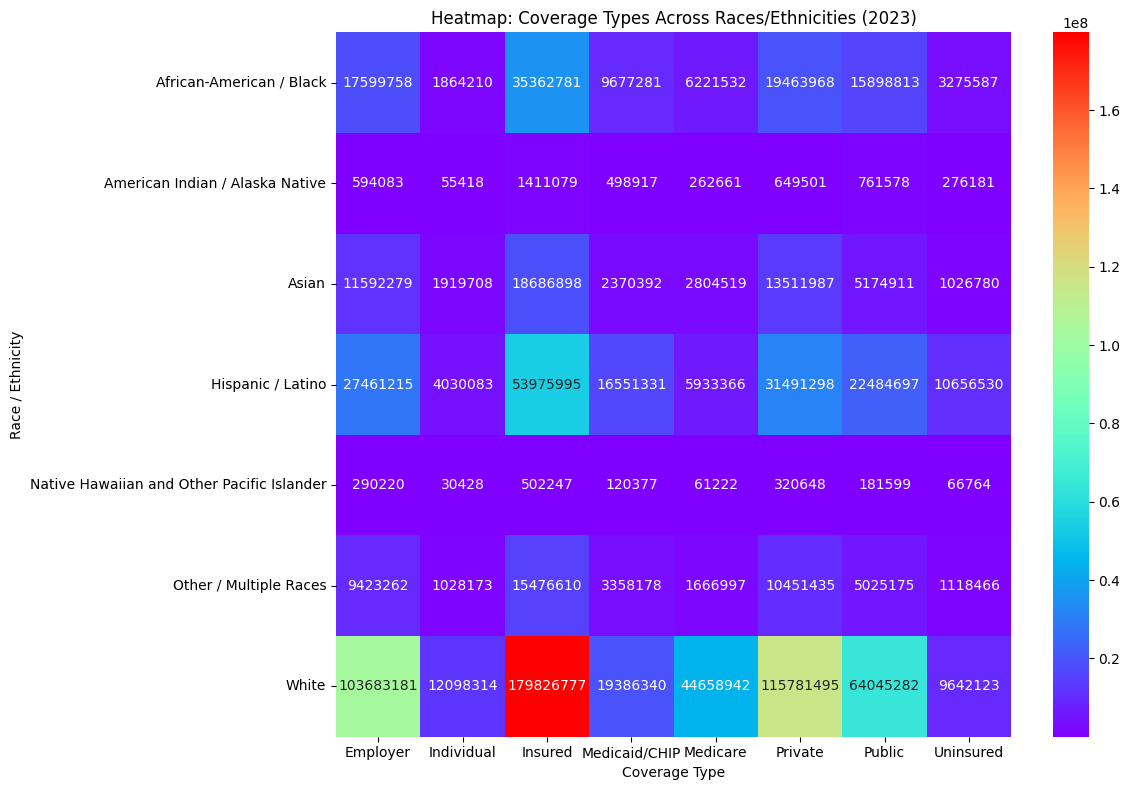

In [50]:
# ============================
# Plot 2: Heatmap (optional and cool)
# ============================
plt.figure(figsize=(12,8))
sns.heatmap(
    pivot,
    annot=True,
    fmt='.0f',
    cmap='rainbow'
)
plt.title(f'Heatmap: Coverage Types Across Races/Ethnicities ({latest_year})')
plt.ylabel('Race / Ethnicity')
plt.xlabel('Coverage Type')
plt.tight_layout()
plt.show()

In [68]:
df_percent = data_race[data_race['Data Type'] == 'Percent']   #reflecting the data published in percentage

# Focus on the latest year available
latest_year = df_percent['TimeFrame'].max()
df_percent_latest = df_percent[df_percent['TimeFrame'] == latest_year]

# Pivot the data: rows = Race/Ethnicity, columns = Coverage Type
pivot_perc = df_percent_latest.pivot_table(
    index='Race / Ethnicity',
    columns='Coverage Type',
    values='Data',
    aggfunc='sum'  # in case there are duplicates
).fillna(0)



In [55]:
pivot_perc

Coverage Type,Employer,Individual,Insured,Medicaid/CHIP,Medicare,Private,Public,Uninsured
Race / Ethnicity,,,,,,,,
African-American / Black,0.45550,0.04825,0.91522,0.25046,0.16102,0.50375,0.41148,0.08478
American Indian / Alaska Native,0.35210,0.03284,0.83631,0.29570,0.15567,0.38494,0.45137,0.16369
Asian,0.58803,0.09738,0.94792,0.12024,0.14226,0.68541,0.26250,0.05208
Hispanic / Latino,0.42488,0.06235,0.83512,0.25608,0.09180,0.48724,0.34789,0.16488
Native Hawaiian and Other Pacific Islander,0.51004,0.05348,0.88267,0.21155,0.10759,0.56352,0.31915,0.11733
Other / Multiple Races,0.56783,0.06196,0.93260,0.20236,0.10045,0.62979,0.30281,0.06740
White,0.54723,0.06385,0.94911,0.10232,0.23571,0.61108,0.33803,0.05089


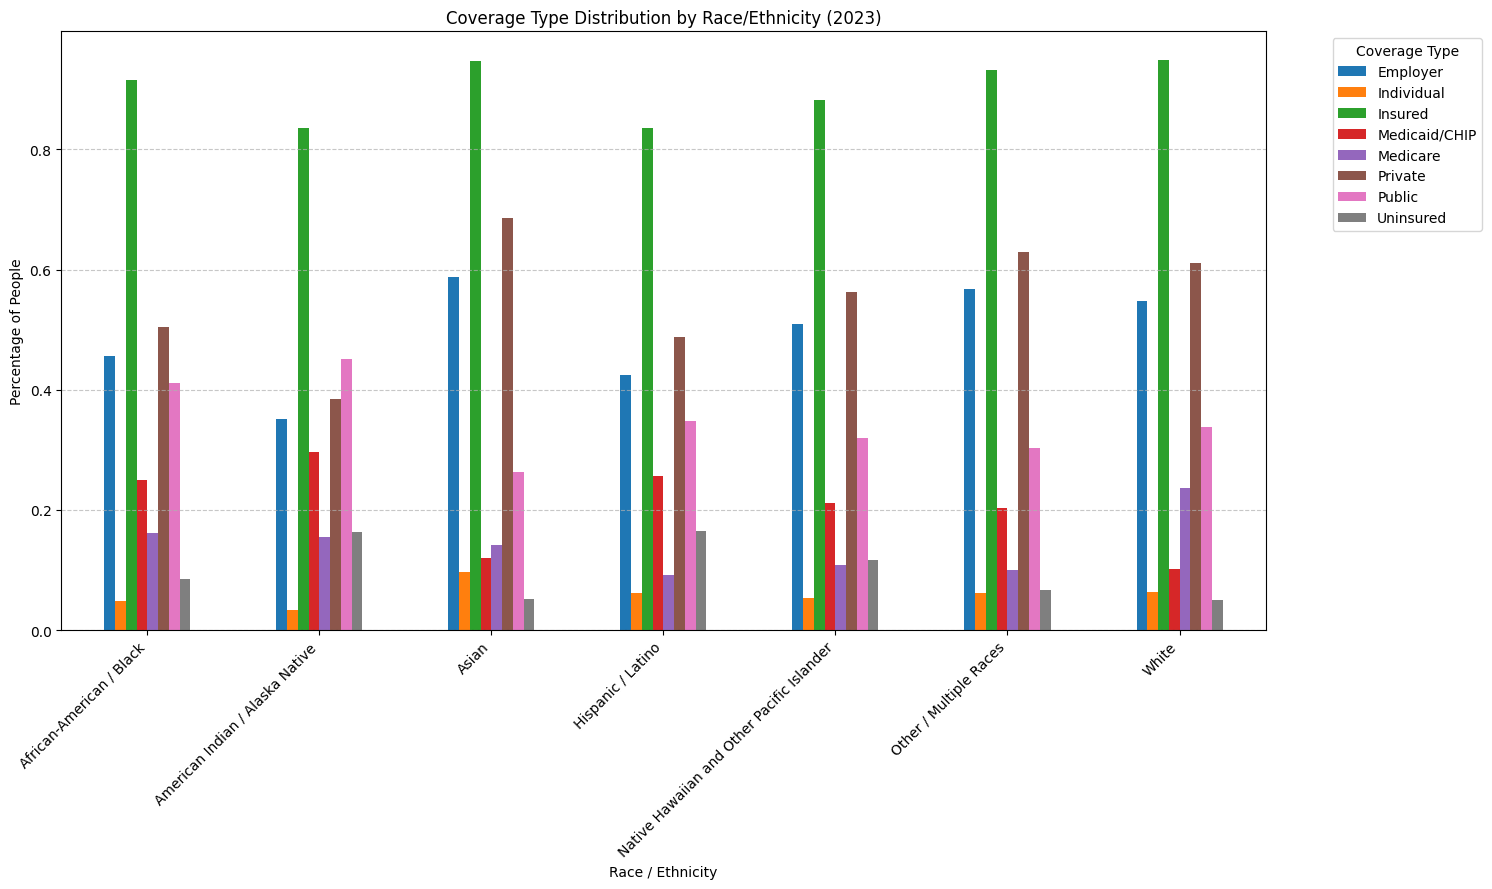

In [69]:
# ============================
# Plot 3: Grouped Bar Chart
# ============================
pivot_perc.plot(kind='bar', figsize=(15,9), stacked=False)
plt.title(f'Coverage Type Distribution by Race/Ethnicity ({latest_year})')
plt.ylabel('Percentage of People')
plt.xlabel('Race / Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Coverage Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**` Animation showing how Coverage Distribution evolved over time accross different years [2021, 2022, 2023]`**

<ipython-input-70-b38f04a2bc60>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(races, rotation=45, ha='right')
<ipython-input-70-b38f04a2bc60>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(races, rotation=45, ha='right')
<ipython-input-70-b38f04a2bc60>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(races, rotation=45, ha='right')
<ipython-input-70-b38f04a2bc60>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(races, rotation=45, ha='right')


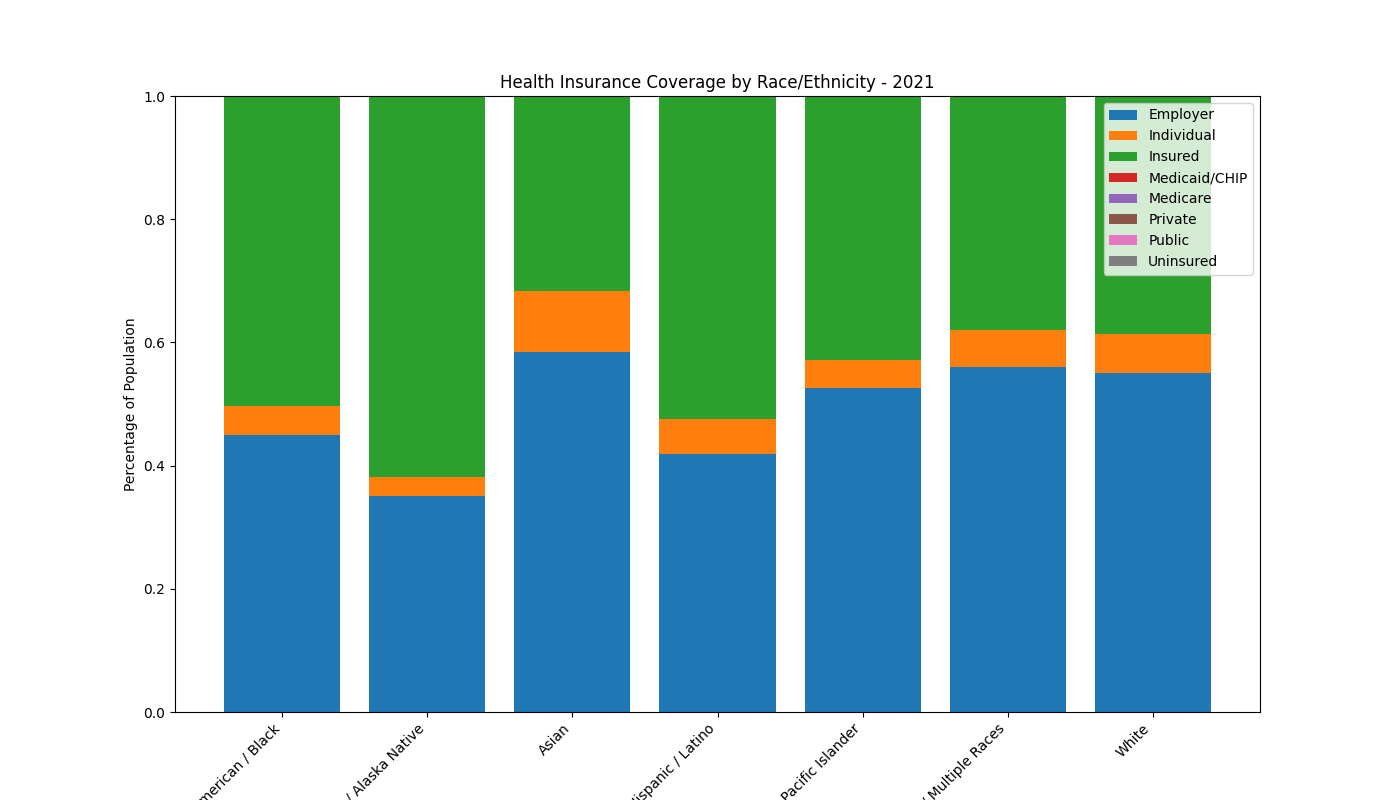

In [70]:
# Pivot the data: index = TimeFrame, Race/Ethnicity; columns = Coverage Type
pivot_percent = df_percent.pivot_table(
    index=['TimeFrame', 'Race / Ethnicity'],
    columns='Coverage Type',
    values='Data',
    aggfunc='sum'
)

# Reset index for easier animation handling
pivot_percent = pivot_percent.reset_index()

# Get unique years and races
years = sorted(pivot_percent['TimeFrame'].unique())
races = pivot_percent['Race / Ethnicity'].unique()
coverage_types = pivot_percent.columns.drop(['TimeFrame', 'Race / Ethnicity'])

# Set up figure
fig, ax = plt.subplots(figsize=(14, 8))

def animate(year_idx):
    ax.clear()
    year = years[year_idx]

    df_year = pivot_percent[pivot_percent['TimeFrame'] == year]
    df_year = df_year.set_index('Race / Ethnicity')

    bottom = pd.Series([0]*len(races), index=races)

    for coverage in coverage_types:
        ax.bar(races, df_year[coverage], bottom=bottom, label=coverage)
        bottom += df_year[coverage]

    ax.set_ylim(0, 1)  # Percent
    ax.set_ylabel('Percentage of Population')
    ax.set_title(f'Health Insurance Coverage by Race/Ethnicity - {year}')
    ax.legend(loc='upper right')
    ax.set_xticklabels(races, rotation=45, ha='right')

ani = animation.FuncAnimation(fig, animate, frames=len(years), interval=1000, repeat=True)

# To save the animation as a GIF
ani.save('insurance_inequality.gif', writer='pillow')

# To display it inside Jupyter Notebook
plt.close()
from IPython.display import Image
Image(filename='insurance_inequality.gif')